This code is used to train a deep learning model on input datasets by performing tabular analysis.
Tried using fast.ai, however I was unable to test new predictions easily. So instead used scikit-learn instead.

# Setting things up...

In [ ]:
# Checking kaggle is connected to the internet
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# Pip installing libraries - can ignore errors
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq numpy==1.26.4 scipy==1.11.3 scikit-learn --force-reinstall pandas

In [1]:
# Importing necessary modules
import csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

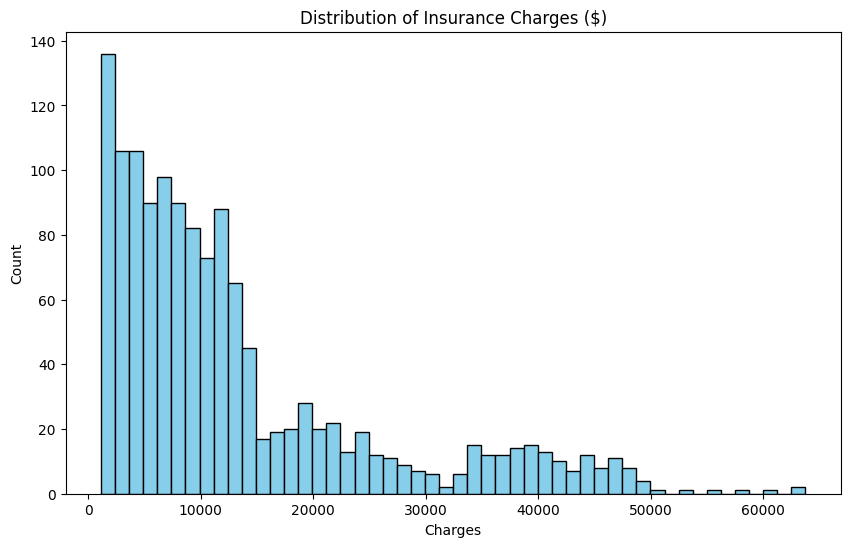

In [2]:
# Finding the dataset
csv_location = '/kaggle/input/insurance-dataset/insurance.csv'
df = pd.read_csv(csv_location)

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(df['charges'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Insurance Charges ($)')
plt.xlabel('Charges')
plt.ylabel('Count')
plt.show()

In [9]:
# --- Define features and target ---
y = np.log(df["charges"])
X = df.drop(columns=["charges"])

# --- Define categorical and continuous columns ---
cat_cols = ['sex', 'smoker', 'region']       # categorical features
cont_cols = ['age', 'bmi', 'children']      # continuous features

# --- Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols), # Categorical data is encoded into binary columns
        ('cont', StandardScaler(), cont_cols) # Continuous data is scaled to mean=0, std=1
    ]
)

# --- Splitting into training and testing data ---
X_train, X_valid, y_train, y_valid = train_test_split(
    X,          # Features
    y,          # Target
    test_size=0.2,    # 20% of data for testing
    random_state=42,  # reproducible split
    shuffle=True      # shuffle before splitting
)

# Uisng scikit-learn Random Forest Regressor

In [10]:
from sklearn.ensemble import RandomForestRegressor

# --- Define model ---
forest_model = RandomForestRegressor(n_estimators=200, # 200 is mix of performance and speed
                                     random_state=42)  # seed for rng

# --- Build full pipeline ---
forest_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", forest_model)
])

# --- Train model ---
forest_pipe.fit(X_train, y_train)

# --- Evaluate ---
forest_preds = forest_pipe.predict(X_valid)
forest_rmse = sqrt(mean_squared_error(y_valid, forest_preds))
print(f"Validation RMSE: {forest_rmse:.4f}")

Validation RMSE: 0.3726


# Using scikit-learn MLPRegressor

In [11]:
from sklearn.neural_network import MLPRegressor

# --- Define neural network model ---
network_model = MLPRegressor(
    hidden_layer_sizes=(128, 64),  # two hidden layers
    activation='relu',             # standard choice
    solver='adam',                 # works will with tabular without much tuning
    learning_rate_init=1e-3,       # common default for adam
    max_iter=500,                  # number of epochs for training
    random_state=42
)

# --- Build full pipeline ---
network_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", network_model)
])

# --- Train model ---
network_pipe.fit(X_train, y_train)

# --- Evaluate ---
network_preds = network_pipe.predict(X_valid)
network_rmse = sqrt(mean_squared_error(y_valid, network_preds))
print(f"Validation RMSE: {network_rmse:.4f}")

Validation RMSE: 0.3621


# Analysing the model

## Plotting Predicted Charge 

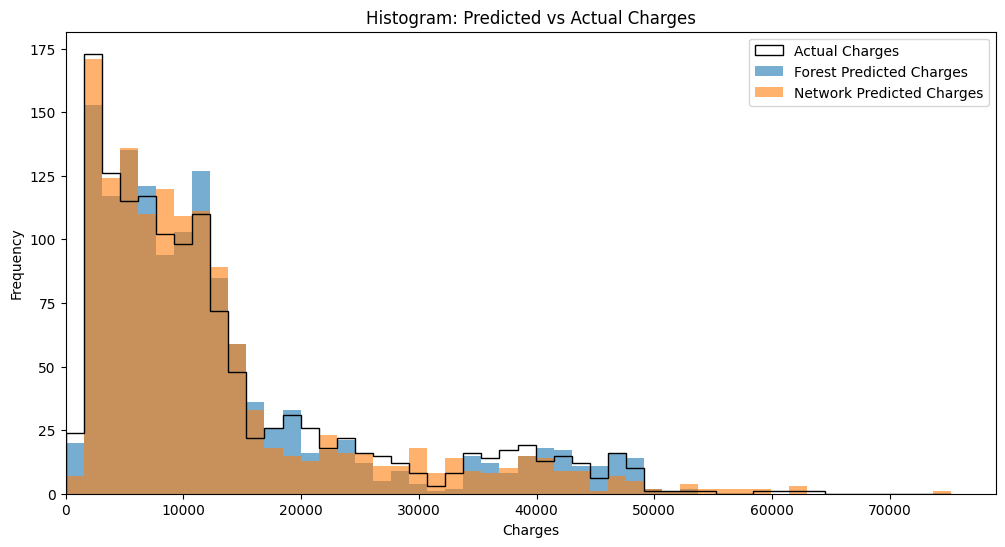

In [37]:
# --- Predict on the entire dataset ---
network_pred_log_charges = network_pipe.predict(X)          # predicted log(x)
network_pred_charges = np.exp(network_pred_log_charges)    # convert back to original scale.

forest_pred_log_charges = forest_pipe.predict(X)          # predicted log(x)
forest_pred_charges = np.exp(forest_pred_log_charges)    # convert back to original scale

actual_charges = np.exp(y)                 # convert actual log values back

# --- Plot histogram ---
plt.figure(figsize=(12,6))

bins = np.linspace(0, max(max(actual_charges), max(forest_pred_charges), max(network_pred_charges)), 50)

plt.hist(actual_charges, bins=bins, histtype='step', linewidth=1, color='black', label='Actual Charges')
plt.hist(forest_pred_charges, bins=bins, alpha=0.6, label='Forest Predicted Charges')
plt.hist(network_pred_charges, bins=bins, alpha=0.6, label='Network Predicted Charges')

plt.xlabel("Charges")
plt.ylabel("Frequency")
plt.title("Histogram: Predicted vs Actual Charges")
plt.legend()
plt.xlim(0)
plt.ylim(0)

plt.show()

## Predict charge using entry from dataset

In [21]:
# --- Example: Predict one row ---
def predict_one_row(x, y, row_number, pipe, actual = False):
    sample_row = x.iloc[[row_number]]   # double brackets to keep it as DataFrame
    prediction_log_charge = pipe.predict(sample_row)
    prediction_charge = np.exp(prediction_log_charge[0])
    
    print(f'Predicted charges: ${prediction_charge:.2f}')
    if actual:
        print(f'Actual charge: ${np.exp(y.iloc[row_number]):.2f}')

predict_one_row(X, y, 0, network_pipe, True)

Predicted charges: $20859.93
Actual charge: $16884.92


## Predict charge using custom data

In [31]:
profile = pd.DataFrame({
    'sex': ['male'],
    'smoker': ['no'],
    'region': ['southeast'],
    'age': [50],
    'bmi': [27.5],
    'children': [0]
})

predict_one_row(profile, y, 0, network_pipe)

Predicted charges: $10524.18
